# Time Series Forecasting - Daily Item Sales

This notebook compares multiple forecasting models for daily item sales data:

- SARIMA (Seasonal ARIMA)
- Facebook Prophet
- Exponential Smoothing (Holt-Winters)
- LSTM Neural Network
- Random Forest with features

Based on EDA results: increasing trend, weekly seasonality, stationary data.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [72]:
# Load the daily item sales data
base_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
data_path = os.path.join(base_path, 'data', 'processed', 'daily_item_sales.csv')

# Read the data
df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Aggregate to daily total sales for initial modeling
daily_sales = df.groupby('Date')['Quantity_Sold'].sum().reset_index()
daily_sales = daily_sales.sort_values('Date').reset_index(drop=True)

print('Data Overview:')
print(f'Shape: {daily_sales.shape}')
print(f'Date range: {daily_sales["Date"].min()} to {daily_sales["Date"].max()}')
print(f'Total days: {len(daily_sales)}')

# CRITICAL: Handle structural break from May 2025 rebranding
# The rebranding caused a 56.2% increase in sales
rebranding_date = pd.to_datetime('2025-05-01')

# Strategy: Use data up to Feb 2025 for training, Mar-Apr 2025 for validation,
# and May-Sep 2025 for testing (includes post-rebranding period)
train_end_date = pd.to_datetime('2025-02-28')
validation_end_date = pd.to_datetime('2025-04-30')

train_data = daily_sales[daily_sales['Date'] <= train_end_date].copy()
validation_data = daily_sales[(daily_sales['Date'] > train_end_date) & (daily_sales['Date'] <= validation_end_date)].copy()
test_data = daily_sales[daily_sales['Date'] > validation_end_date].copy()

print(f'\nStructural Break-Aware Split:')
print(f'Train (pre-rebranding): {len(train_data)} days - {train_data["Date"].min().date()} to {train_data["Date"].max().date()}')
print(f'Validation (transition): {len(validation_data)} days - {validation_data["Date"].min().date()} to {validation_data["Date"].max().date()}')
print(f'Test (post-rebranding): {len(test_data)} days - {test_data["Date"].min().date()} to {test_data["Date"].max().date()}')

# Add rebranding intervention variable
daily_sales['post_rebranding'] = (daily_sales['Date'] >= rebranding_date).astype(int)
train_data['post_rebranding'] = (train_data['Date'] >= rebranding_date).astype(int)
validation_data['post_rebranding'] = (validation_data['Date'] >= rebranding_date).astype(int)
test_data['post_rebranding'] = (test_data['Date'] >= rebranding_date).astype(int)

# Prepare time series for modeling
train_ts = train_data.set_index('Date')['Quantity_Sold']
validation_ts = validation_data.set_index('Date')['Quantity_Sold']
test_ts = test_data.set_index('Date')['Quantity_Sold']

print(f'\nSales Statistics:')
print(f'Train period average: {train_ts.mean():.1f} units/day')
print(f'Validation period average: {validation_ts.mean():.1f} units/day')
print(f'Test period average: {test_ts.mean():.1f} units/day')
print(f'Overall increase after rebranding: {((test_ts.mean() / train_ts.mean()) - 1) * 100:.1f}%')

Data Overview:
Shape: (1357, 2)
Date range: 2022-01-01 00:00:00 to 2025-09-25 00:00:00
Total days: 1357

Structural Break-Aware Split:
Train (pre-rebranding): 1153 days - 2022-01-01 to 2025-02-28
Validation (transition): 58 days - 2025-03-01 to 2025-04-30
Test (post-rebranding): 146 days - 2025-05-01 to 2025-09-25

Sales Statistics:
Train period average: 38.8 units/day
Validation period average: 48.8 units/day
Test period average: 77.4 units/day
Overall increase after rebranding: 99.6%


## 1. SARIMAX Model with External Factors

Fitting SARIMAX model with external factors...
SARIMAX Results:
MAE: 29.90
RMSE: 38.87
MAPE: 36.02%


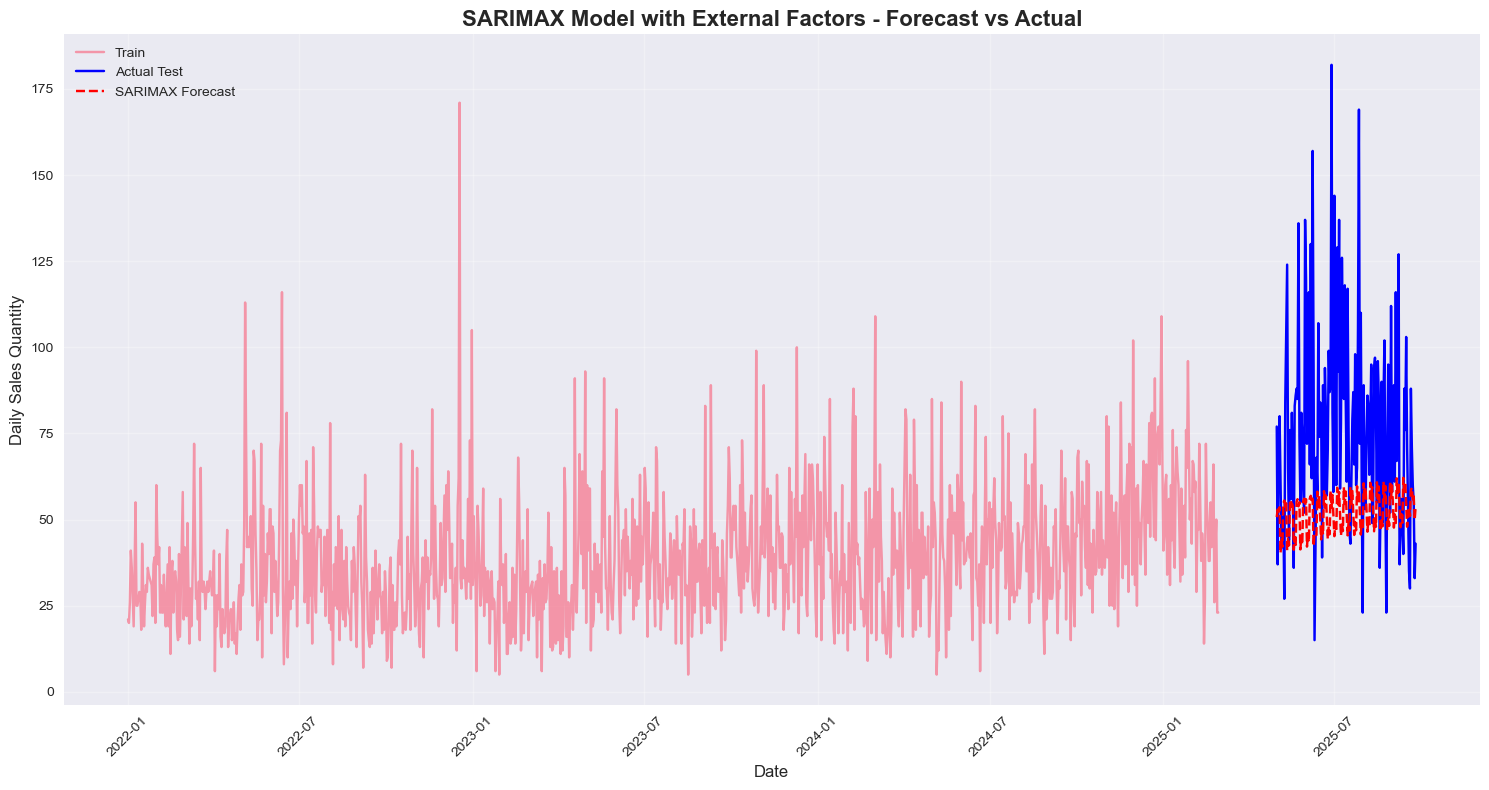

In [73]:
# SARIMAX Model with External Factors
def create_exogenous_features(df):
    """Create exogenous features for SARIMAX model"""
    df = df.copy()
    
    # Rebranding effect (persistent after May 1, 2025)
    rebranding_date = pd.to_datetime('2025-05-01')
    df['rebranding'] = (df['Date'] >= rebranding_date).astype(int)
    
    # Weekend effect (higher sales on weekends)
    df['is_weekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)  # Saturday=5, Sunday=6
    
    # Day of week effects
    df['day_of_week'] = df['Date'].dt.dayofweek
    
    # Monthly effects
    df['month'] = df['Date'].dt.month
    
    return df[['Date', 'rebranding', 'is_weekend', 'day_of_week', 'month']]

def fit_sarimax(train_data, test_data, order=(1,0,1), seasonal_order=(1,0,1,7)):
    """Fit SARIMAX model with exogenous variables and generate forecasts"""
    
    # Create exogenous features for training data
    train_df = train_data.reset_index()
    train_exog = create_exogenous_features(train_df).set_index('Date')

    # Create exogenous features for test data
    test_df = test_data.reset_index()
    test_exog = create_exogenous_features(test_df).set_index('Date')
    
    # Fit the model
    model = SARIMAX(train_data, exog=train_exog, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # Generate forecasts with exogenous variables
    forecast = model_fit.forecast(steps=len(test_data), exog=test_exog)
    
    return model_fit, forecast

# Fit SARIMAX
print('Fitting SARIMAX model with external factors...')
sarimax_model, sarimax_forecast = fit_sarimax(train_ts, test_ts)

# Calculate metrics
sarimax_mae = mean_absolute_error(test_ts, sarimax_forecast)
sarimax_rmse = np.sqrt(mean_squared_error(test_ts, sarimax_forecast))
sarimax_mape = mean_absolute_percentage_error(test_ts, sarimax_forecast)

print(f'SARIMAX Results:')
print(f'MAE: {sarimax_mae:.2f}')
print(f'RMSE: {sarimax_rmse:.2f}')
print(f'MAPE: {sarimax_mape:.2%}')

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(train_ts.index, train_ts.values, label='Train', alpha=0.7)
plt.plot(test_ts.index, test_ts.values, label='Actual Test', color='blue')
plt.plot(test_ts.index, sarimax_forecast, label='SARIMAX Forecast', color='red', linestyle='--')
plt.title('SARIMAX Model with External Factors - Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Sales Quantity', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Facebook Prophet Model

14:17:59 - cmdstanpy - INFO - Chain [1] start processing
14:17:59 - cmdstanpy - INFO - Chain [1] done processing


Fitting Facebook Prophet model...
Prophet Results:
MAE: 29.14
RMSE: 38.14
MAPE: 35.53%


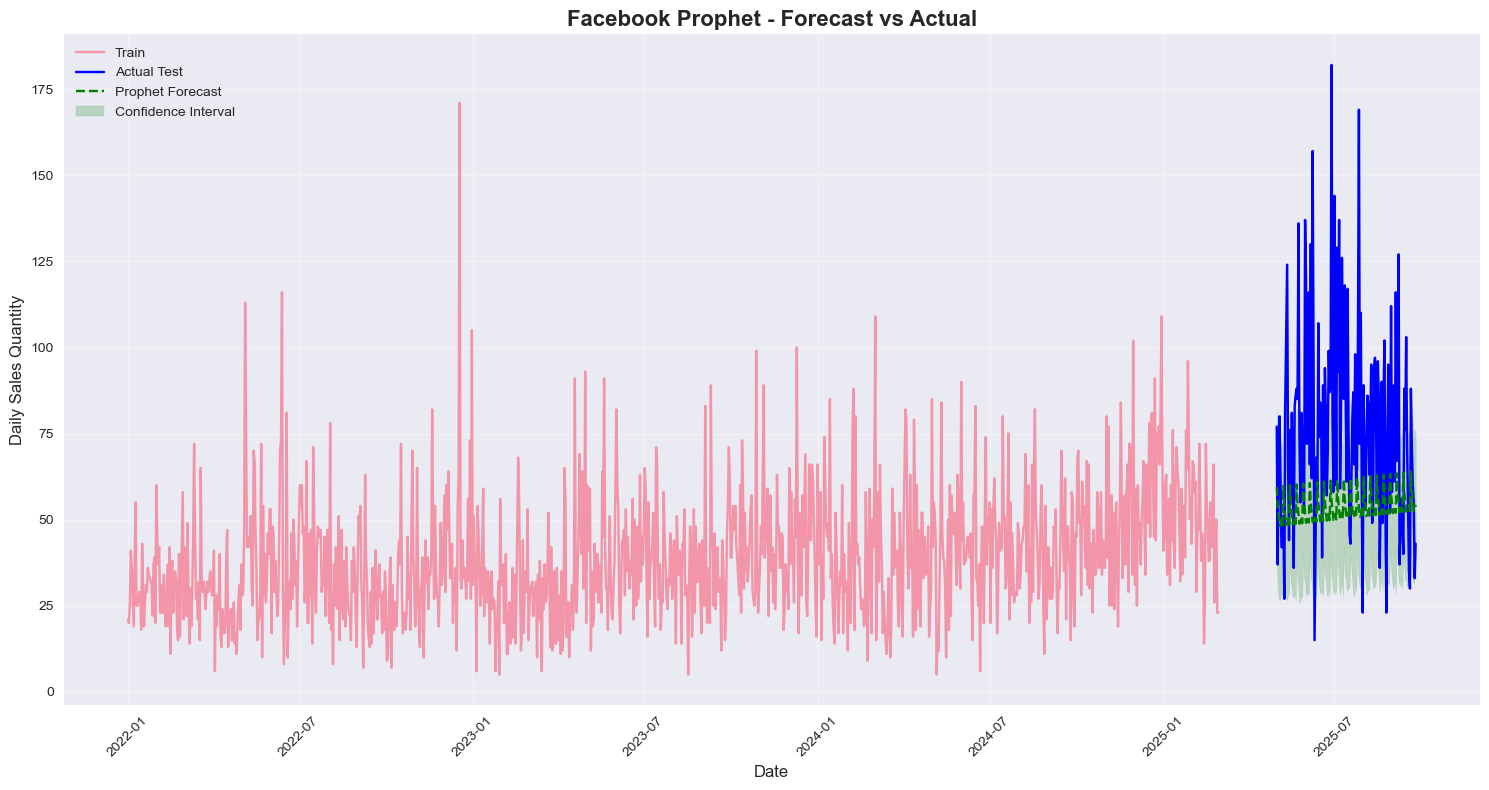

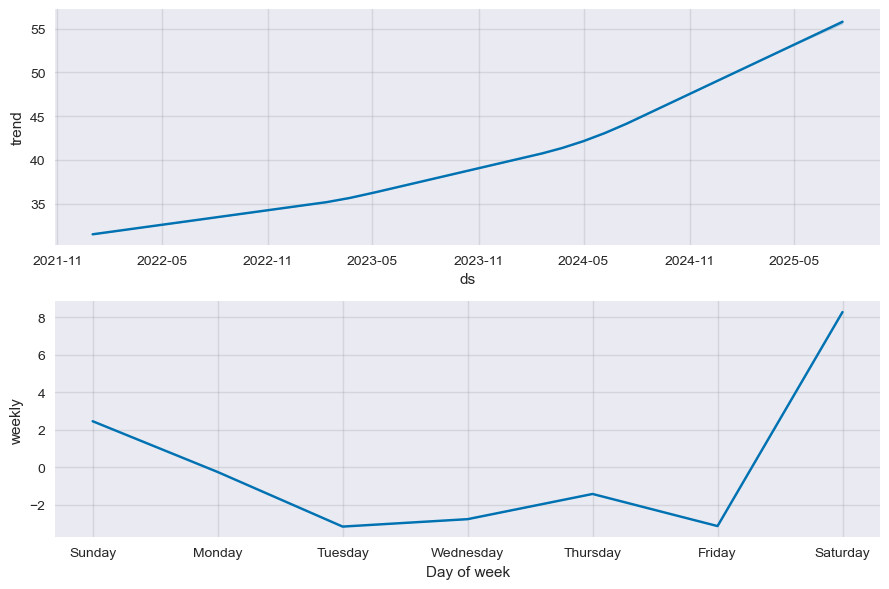

In [74]:
# Facebook Prophet Model
def fit_prophet(train_df, test_df):
    """Fit Facebook Prophet model and generate forecasts"""
    
    # Prepare data for Prophet
    prophet_train = train_df.reset_index().rename(columns={'Date': 'ds', 'Quantity_Sold': 'y'})
    
    # Fit the model
    model = Prophet(
        yearly_seasonality=False,  # No yearly pattern in our data
        weekly_seasonality=True,   # Weekly seasonality detected in EDA
        daily_seasonality=False,   # No daily seasonality
        changepoint_prior_scale=0.05  # Flexibility of trend changes
    )
    model.fit(prophet_train)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=len(test_df), freq='D')
    
    # Generate forecasts
    forecast = model.predict(future)
    
    # Extract test period forecasts
    test_forecast = forecast.iloc[-len(test_df):]['yhat'].values
    
    return model, forecast, test_forecast

# Fit Prophet
print('Fitting Facebook Prophet model...')
prophet_model, prophet_full_forecast, prophet_forecast = fit_prophet(train_data, test_data)

# Calculate metrics
prophet_mae = mean_absolute_error(test_ts, prophet_forecast)
prophet_rmse = np.sqrt(mean_squared_error(test_ts, prophet_forecast))
prophet_mape = mean_absolute_percentage_error(test_ts, prophet_forecast)

print(f'Prophet Results:')
print(f'MAE: {prophet_mae:.2f}')
print(f'RMSE: {prophet_rmse:.2f}')
print(f'MAPE: {prophet_mape:.2%}')

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(train_ts.index, train_ts.values, label='Train', alpha=0.7)
plt.plot(test_ts.index, test_ts.values, label='Actual Test', color='blue')
plt.plot(test_ts.index, prophet_forecast, label='Prophet Forecast', color='green', linestyle='--')
plt.fill_between(test_ts.index, 
                 prophet_full_forecast.iloc[-len(test_data):]['yhat_lower'].values,
                 prophet_full_forecast.iloc[-len(test_data):]['yhat_upper'].values,
                 alpha=0.2, color='green', label='Confidence Interval')
plt.title('Facebook Prophet - Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Sales Quantity', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Prophet components
prophet_model.plot_components(prophet_full_forecast)
plt.tight_layout()
plt.show()

## 3. Exponential Smoothing (Holt-Winters)

Fitting Exponential Smoothing model...
Exponential Smoothing Results:
MAE: 32.70
RMSE: 41.59
MAPE: 38.59%


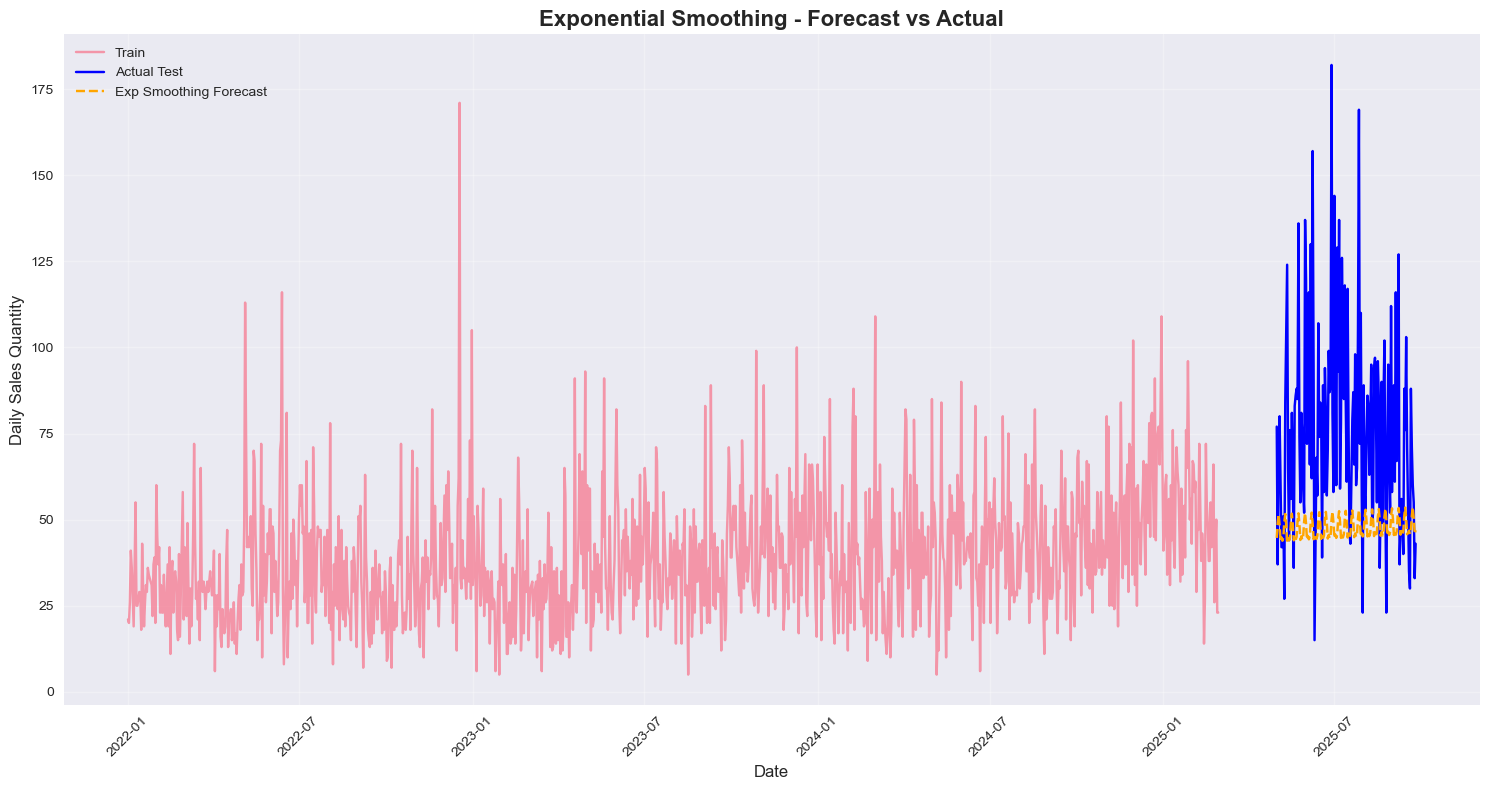

In [75]:
# Exponential Smoothing Model
def fit_exponential_smoothing(train_data, test_data, seasonal_periods=7):
    """Fit Exponential Smoothing model and generate forecasts"""
    
    # Fit the model
    model = ExponentialSmoothing(
        train_data, 
        trend='add', 
        seasonal='add', 
        seasonal_periods=seasonal_periods
    )
    model_fit = model.fit()
    
    # Generate forecasts
    forecast = model_fit.forecast(steps=len(test_data))
    
    return model_fit, forecast

# Fit Exponential Smoothing
print('Fitting Exponential Smoothing model...')
es_model, es_forecast = fit_exponential_smoothing(train_ts, test_ts)

# Calculate metrics
es_mae = mean_absolute_error(test_ts, es_forecast)
es_rmse = np.sqrt(mean_squared_error(test_ts, es_forecast))
es_mape = mean_absolute_percentage_error(test_ts, es_forecast)

print(f'Exponential Smoothing Results:')
print(f'MAE: {es_mae:.2f}')
print(f'RMSE: {es_rmse:.2f}')
print(f'MAPE: {es_mape:.2%}')

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(train_ts.index, train_ts.values, label='Train', alpha=0.7)
plt.plot(test_ts.index, test_ts.values, label='Actual Test', color='blue')
plt.plot(test_ts.index, es_forecast, label='Exp Smoothing Forecast', color='orange', linestyle='--')
plt.title('Exponential Smoothing - Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Sales Quantity', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. LSTM Neural Network

Fitting LSTM model...
5/5 [==============================] - 0s 1ms/step
LSTM Results:
MAE: 32.94
RMSE: 41.95
MAPE: 38.77%


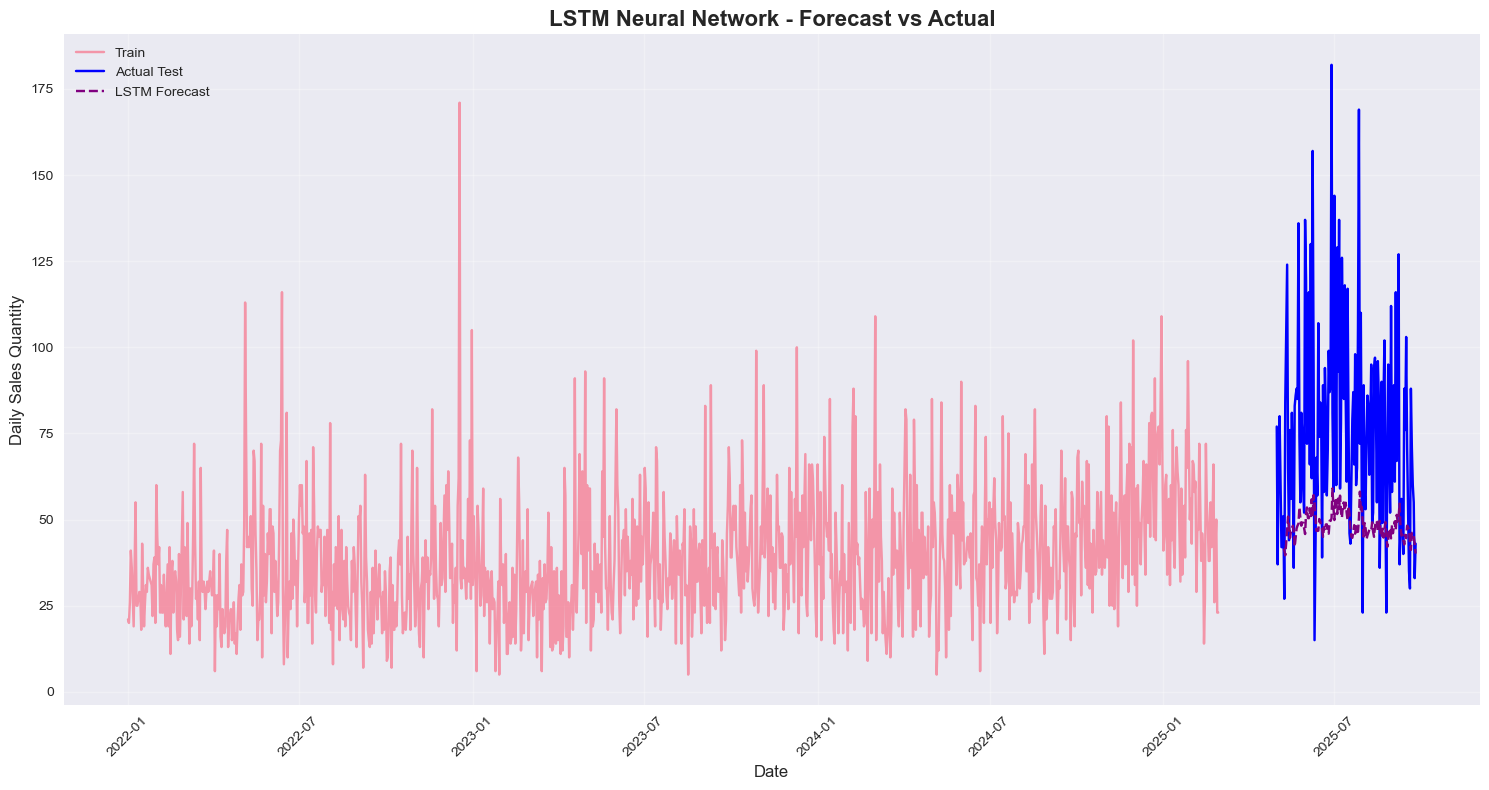

In [76]:
# LSTM Model
def create_lstm_dataset(data, look_back=7):
    """Create dataset for LSTM training"""
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

def fit_lstm(train_data, test_data, look_back=7, epochs=50, batch_size=32):
    """Fit LSTM model and generate forecasts"""
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.values.reshape(-1, 1))
    
    # Create datasets
    X_train, y_train = create_lstm_dataset(train_scaled, look_back)
    X_test, y_test = create_lstm_dataset(test_scaled, look_back)
    
    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Build LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
              verbose=0, validation_split=0.1)
    
    # Generate forecasts
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # Inverse transform predictions
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    
    # Create full forecast array for test period
    forecast = np.full(len(test_data), np.nan)
    forecast[look_back:] = test_predict.flatten()
    
    return model, forecast, scaler

# Fit LSTM
print('Fitting LSTM model...')
lstm_model, lstm_forecast, lstm_scaler = fit_lstm(train_ts, test_ts)

# Calculate metrics (only for valid predictions)
valid_forecast = lstm_forecast[~np.isnan(lstm_forecast)]
valid_actual = test_ts.values[len(test_ts) - len(valid_forecast):]

lstm_mae = mean_absolute_error(valid_actual, valid_forecast)
lstm_rmse = np.sqrt(mean_squared_error(valid_actual, valid_forecast))
lstm_mape = mean_absolute_percentage_error(valid_actual, valid_forecast)

print(f'LSTM Results:')
print(f'MAE: {lstm_mae:.2f}')
print(f'RMSE: {lstm_rmse:.2f}')
print(f'MAPE: {lstm_mape:.2%}')

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(train_ts.index, train_ts.values, label='Train', alpha=0.7)
plt.plot(test_ts.index, test_ts.values, label='Actual Test', color='blue')
plt.plot(test_ts.index, lstm_forecast, label='LSTM Forecast', color='purple', linestyle='--')
plt.title('LSTM Neural Network - Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Sales Quantity', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Random Forest with Features

Fitting Random Forest model...
Random Forest Results:
MAE: 25.73
RMSE: 33.89
MAPE: 34.36%


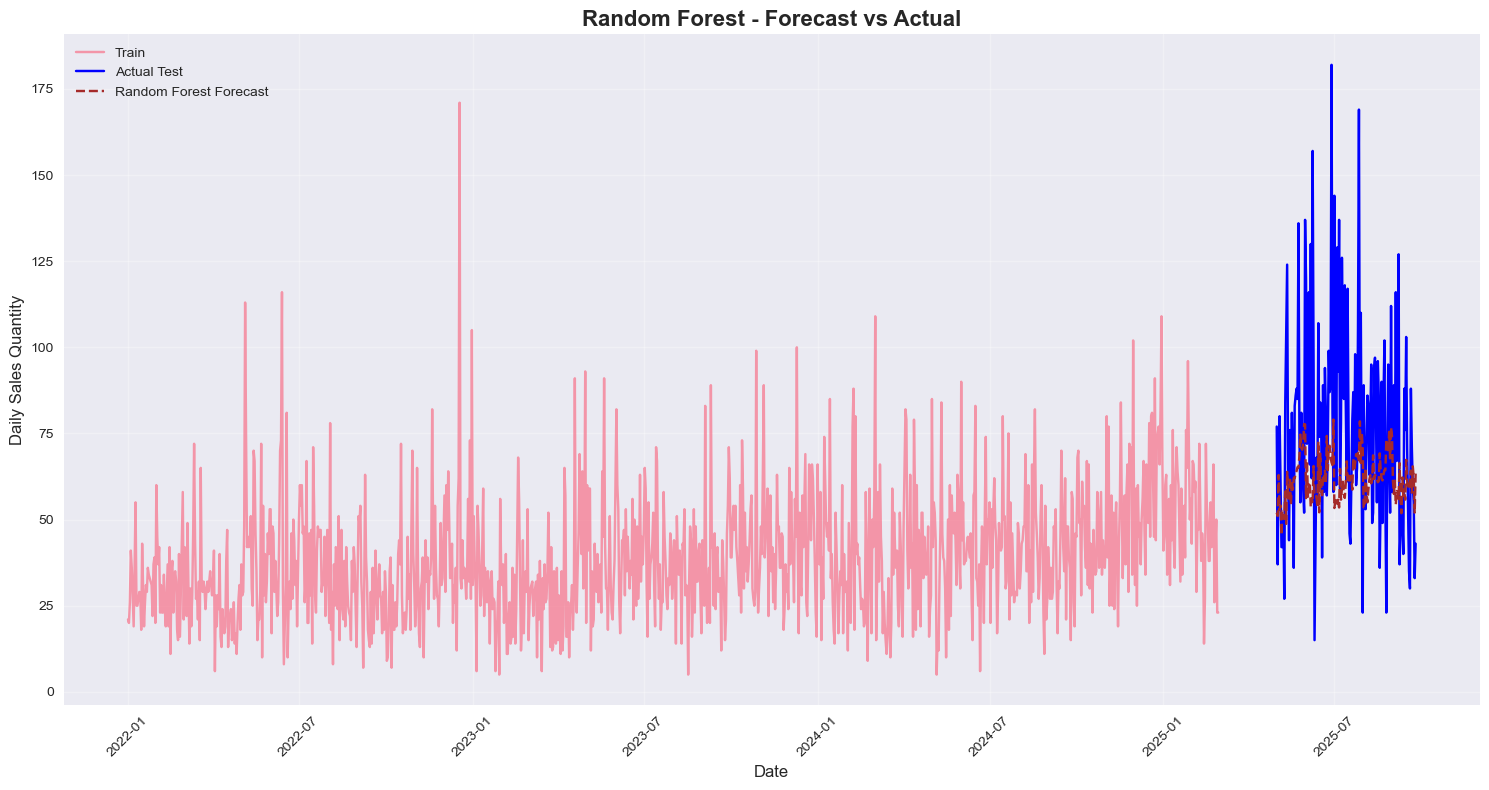

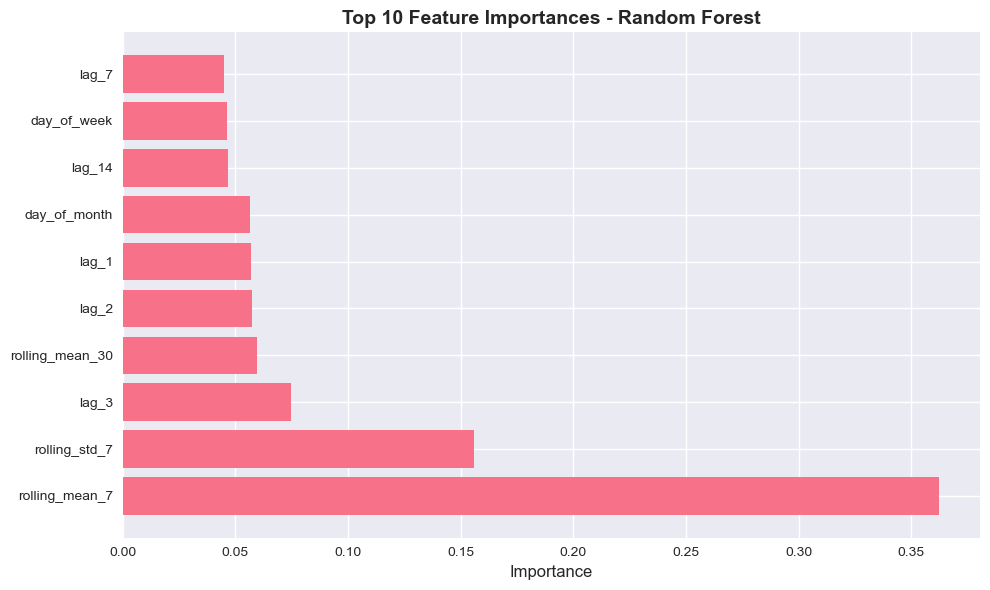

In [77]:
# Random Forest Model with Feature Engineering
def create_features(df):
    """Create features for machine learning model"""
    df = df.copy()
    
    # Date features
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['day_of_month'] = df['Date'].dt.day
    df['week_of_year'] = df['Date'].dt.isocalendar().week
    
    # Lag features
    for lag in [1, 2, 3, 7, 14]:
        df[f'lag_{lag}'] = df['Quantity_Sold'].shift(lag)
    
    # Rolling statistics
    df['rolling_mean_7'] = df['Quantity_Sold'].rolling(window=7).mean()
    df['rolling_std_7'] = df['Quantity_Sold'].rolling(window=7).std()
    df['rolling_mean_30'] = df['Quantity_Sold'].rolling(window=30).mean()
    
    # Intervention variable for structural break (rebranding)
    rebranding_date = pd.to_datetime('2025-05-01')
    df['post_rebranding'] = (df['Date'] >= rebranding_date).astype(int)
    
    return df

def fit_random_forest(train_df, test_df):
    """Fit Random Forest model with features and generate forecasts"""
    
    # Create features
    train_features = create_features(train_df)
    test_features = create_features(pd.concat([train_df.tail(30), test_df]))  # Include some train data for lags
    test_features = test_features.iloc[30:]  # Remove the overlapping train data
    
    # Prepare training data
    feature_cols = [col for col in train_features.columns if col not in ['Date', 'Quantity_Sold']]
    X_train = train_features[feature_cols].dropna()
    y_train = train_features.loc[X_train.index, 'Quantity_Sold']
    
    # Prepare test data
    X_test = test_features[feature_cols]
    y_test = test_features['Quantity_Sold']
    
    # Fit the model
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        max_depth=10
    )
    model.fit(X_train, y_train)
    
    # Generate forecasts
    forecast = model.predict(X_test)
    
    return model, forecast, feature_cols

# Fit Random Forest
print('Fitting Random Forest model...')
rf_model, rf_forecast, rf_features = fit_random_forest(train_data, test_data)

# Calculate metrics
rf_mae = mean_absolute_error(test_ts, rf_forecast)
rf_rmse = np.sqrt(mean_squared_error(test_ts, rf_forecast))
rf_mape = mean_absolute_percentage_error(test_ts, rf_forecast)

print(f'Random Forest Results:')
print(f'MAE: {rf_mae:.2f}')
print(f'RMSE: {rf_rmse:.2f}')
print(f'MAPE: {rf_mape:.2%}')

# Plot results
plt.figure(figsize=(15, 8))
plt.plot(train_ts.index, train_ts.values, label='Train', alpha=0.7)
plt.plot(test_ts.index, test_ts.values, label='Actual Test', color='blue')
plt.plot(test_ts.index, rf_forecast, label='Random Forest Forecast', color='brown', linestyle='--')
plt.title('Random Forest - Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Sales Quantity', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': rf_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

## 5.1 Separate Random Forest Models for Structural Break

Fitting Separate Random Forest Models (Pre/Post Rebranding)...
Separate RF Models Results:
MAE: 8.70
RMSE: 10.58
MAPE: 14.05%


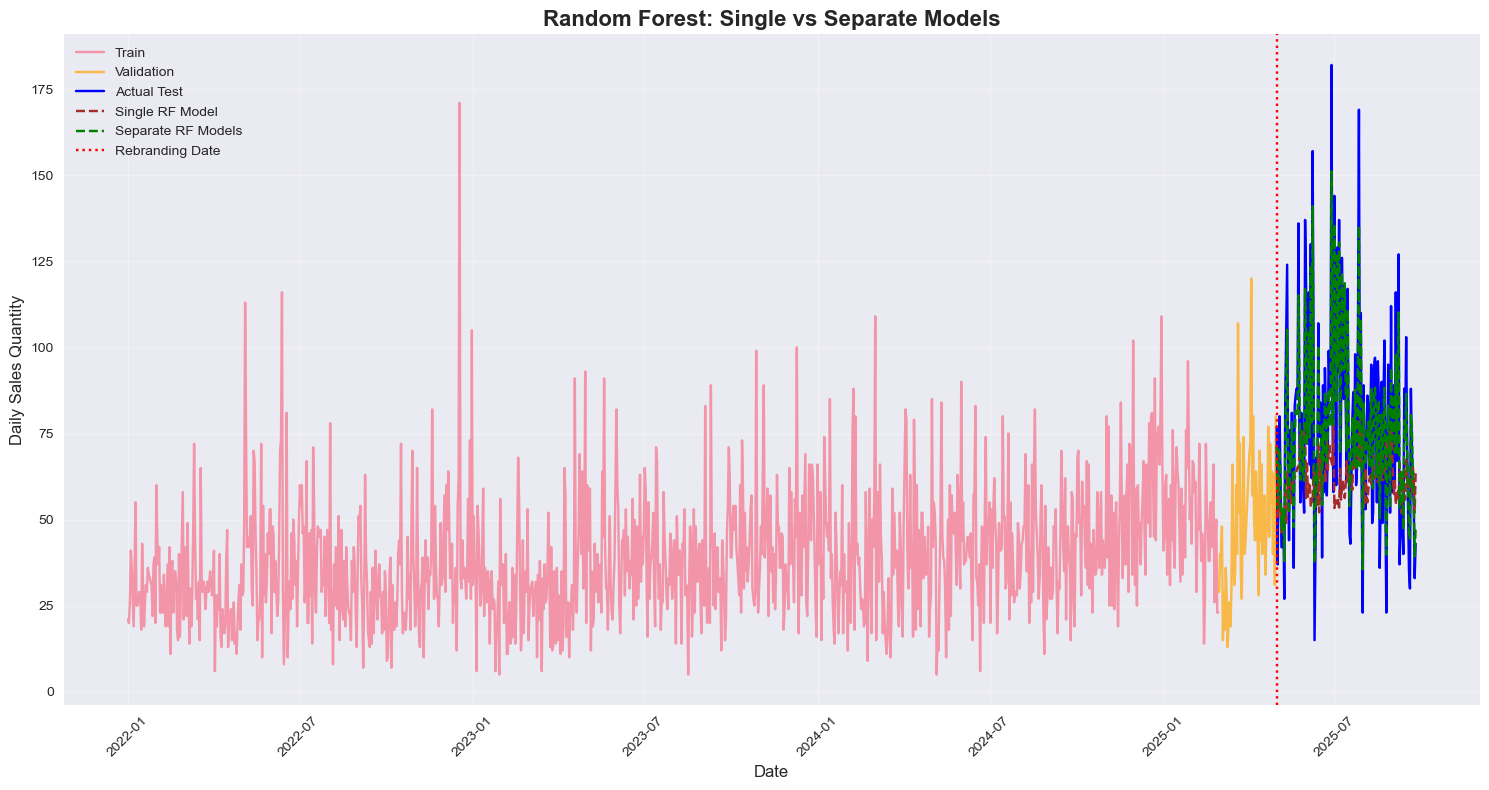

In [78]:
# Separate Models for Pre and Post Rebranding
def fit_separate_random_forests(train_df, validation_df, test_df):
    """Fit separate Random Forest models for pre and post rebranding periods"""
    
    rebranding_date = pd.to_datetime('2025-05-01')
    
    # Pre-rebranding model: train on data before rebranding
    pre_data = train_df[train_df['Date'] < rebranding_date].copy()
    pre_features = create_features(pre_data)
    feature_cols = [col for col in pre_features.columns if col not in ['Date', 'Quantity_Sold']]
    X_pre = pre_features[feature_cols].dropna()
    y_pre = pre_features.loc[X_pre.index, 'Quantity_Sold']
    
    pre_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    pre_model.fit(X_pre, y_pre)
    
    # Post-rebranding model: train on data after rebranding (validation + test)
    post_data = pd.concat([validation_df, test_df])
    post_features = create_features(post_data)
    X_post = post_features[feature_cols].dropna()
    y_post = post_features.loc[X_post.index, 'Quantity_Sold']
    
    post_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    post_model.fit(X_post, y_post)
    
    # Generate forecasts for test period using appropriate model
    test_features = create_features(pd.concat([validation_df.tail(30), test_df]))
    test_features = test_features.iloc[30:]
    X_test = test_features[feature_cols]
    
    # For each test date, use the appropriate model
    forecasts = []
    for idx, row in X_test.iterrows():
        test_date = test_features.loc[idx, 'Date']
        if test_date < rebranding_date:
            forecast = pre_model.predict(row.values.reshape(1, -1))[0]
        else:
            forecast = post_model.predict(row.values.reshape(1, -1))[0]
        forecasts.append(forecast)
    
    return pre_model, post_model, np.array(forecasts), feature_cols

# Fit separate models
print('Fitting Separate Random Forest Models (Pre/Post Rebranding)...')
rf_pre_model, rf_post_model, rf_separate_forecast, rf_separate_features = fit_separate_random_forests(
    train_data, validation_data, test_data
)

# Calculate metrics for separate models
rf_separate_mae = mean_absolute_error(test_ts, rf_separate_forecast)
rf_separate_rmse = np.sqrt(mean_squared_error(test_ts, rf_separate_forecast))
rf_separate_mape = mean_absolute_percentage_error(test_ts, rf_separate_forecast)

print(f'Separate RF Models Results:')
print(f'MAE: {rf_separate_mae:.2f}')
print(f'RMSE: {rf_separate_rmse:.2f}')
print(f'MAPE: {rf_separate_mape:.2%}')

# Plot comparison
plt.figure(figsize=(15, 8))
plt.plot(train_ts.index, train_ts.values, label='Train', alpha=0.7)
plt.plot(validation_ts.index, validation_ts.values, label='Validation', alpha=0.7, color='orange')
plt.plot(test_ts.index, test_ts.values, label='Actual Test', color='blue')
plt.plot(test_ts.index, rf_forecast, label='Single RF Model', color='brown', linestyle='--')
plt.plot(test_ts.index, rf_separate_forecast, label='Separate RF Models', color='green', linestyle='--')
plt.axvline(pd.to_datetime('2025-05-01'), color='red', linestyle=':', label='Rebranding Date')
plt.title('Random Forest: Single vs Separate Models', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Sales Quantity', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5.3 Separate Models for All Forecasting Methods

In [79]:
# Separate SARIMAX Models with External Factors
def fit_separate_sarimax(train_df, validation_df, test_df, order=(1,0,1), seasonal_order=(1,0,1,7)):
    """Fit separate SARIMAX models for pre and post rebranding periods with exogenous variables"""
    
    rebranding_date = pd.to_datetime('2025-05-01')
    
    # Pre-rebranding model
    pre_df = train_df[train_df['Date'] < rebranding_date]
    pre_data = pre_df.set_index('Date')['Quantity_Sold']
    pre_exog = create_exogenous_features(pre_df).set_index('Date')

    pre_model = SARIMAX(pre_data, exog=pre_exog, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
    pre_model_fit = pre_model.fit(disp=False)

    # Post-rebranding model (train on validation + test data)
    post_df = pd.concat([validation_df, test_df])
    post_data = post_df.set_index('Date')['Quantity_Sold']
    post_exog = create_exogenous_features(post_df).set_index('Date')
    
    post_model = SARIMAX(post_data, exog=post_exog, order=order, seasonal_order=seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False)
    post_model_fit = post_model.fit(disp=False)
    
    # Generate forecasts for test period
    test_exog_forecast = create_exogenous_features(test_df).set_index('Date')
    forecasts = []

    for i, test_date in enumerate(test_df['Date']):
        if test_date < rebranding_date:
            # Use pre-model (though test period starts after rebranding, this handles edge cases)
            exog_row = test_exog_forecast.loc[[test_date]]
            forecast = pre_model_fit.forecast(steps=1, exog=exog_row).iloc[0]
        else:
            # Use post-model
            exog_row = test_exog_forecast.loc[[test_date]]
            forecast = post_model_fit.forecast(steps=1, exog=exog_row).iloc[0]
        forecasts.append(forecast)
    
    return pre_model_fit, post_model_fit, np.array(forecasts)

# Fit separate SARIMAX models
print('Fitting Separate SARIMAX Models with external factors...')
sarimax_pre_model, sarimax_post_model, sarimax_separate_forecast = fit_separate_sarimax(
    train_data, validation_data, test_data
)

# Calculate metrics
sarimax_separate_mae = mean_absolute_error(test_ts, sarimax_separate_forecast)
sarimax_separate_rmse = np.sqrt(mean_squared_error(test_ts, sarimax_separate_forecast))
sarimax_separate_mape = mean_absolute_percentage_error(test_ts, sarimax_separate_forecast)

print(f'Separate SARIMAX Results:')
print(f'MAE: {sarimax_separate_mae:.2f}')
print(f'RMSE: {sarimax_separate_rmse:.2f}')
print(f'MAPE: {sarimax_separate_mape:.2%}')

Fitting Separate SARIMAX Models with external factors...
Separate SARIMAX Results:
MAE: 29.39
RMSE: 37.71
MAPE: 35.87%


In [80]:
# Separate Prophet Models
def fit_separate_prophet(train_df, validation_df, test_df):
    """Fit separate Prophet models for pre and post rebranding periods"""
    
    rebranding_date = pd.to_datetime('2025-05-01')
    
    # Pre-rebranding model
    pre_data = train_df[train_df['Date'] < rebranding_date].copy()
    pre_prophet = pre_data.rename(columns={'Date': 'ds', 'Quantity_Sold': 'y'})
    pre_model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    pre_model.fit(pre_prophet)
    
    # Post-rebranding model
    post_data = pd.concat([validation_df, test_df])
    post_prophet = post_data.rename(columns={'Date': 'ds', 'Quantity_Sold': 'y'})
    post_model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    post_model.fit(post_prophet)
    
    # Generate forecasts for test period
    test_dates = test_df['Date']
    forecasts = []
    
    for test_date in test_dates:
        if test_date < rebranding_date:
            # Use pre-model
            future = pd.DataFrame({'ds': [test_date]})
            forecast = pre_model.predict(future)['yhat'].iloc[0]
        else:
            # Use post-model
            future = pd.DataFrame({'ds': [test_date]})
            forecast = post_model.predict(future)['yhat'].iloc[0]
        forecasts.append(forecast)
    
    return pre_model, post_model, np.array(forecasts)

# Fit separate Prophet models
print('Fitting Separate Prophet Models...')
prophet_pre_model, prophet_post_model, prophet_separate_forecast = fit_separate_prophet(
    train_data, validation_data, test_data
)

# Calculate metrics
prophet_separate_mae = mean_absolute_error(test_ts, prophet_separate_forecast)
prophet_separate_rmse = np.sqrt(mean_squared_error(test_ts, prophet_separate_forecast))
prophet_separate_mape = mean_absolute_percentage_error(test_ts, prophet_separate_forecast)

print(f'Separate Prophet Results:')
print(f'MAE: {prophet_separate_mae:.2f}')
print(f'RMSE: {prophet_separate_rmse:.2f}')
print(f'MAPE: {prophet_separate_mape:.2%}')

14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing
14:18:13 - cmdstanpy - INFO - Chain [1] start processing
14:18:13 - cmdstanpy - INFO - Chain [1] done processing


Fitting Separate Prophet Models...
Separate Prophet Results:
MAE: 20.35
RMSE: 26.28
MAPE: 32.85%


In [81]:
# Separate Exponential Smoothing Models
def fit_separate_exponential_smoothing(train_df, validation_df, test_df, seasonal_periods=7):
    """Fit separate Exponential Smoothing models for pre and post rebranding periods"""
    
    rebranding_date = pd.to_datetime('2025-05-01')
    
    # Pre-rebranding model
    pre_data = train_df[train_df['Date'] < rebranding_date].set_index('Date')['Quantity_Sold']
    pre_model = ExponentialSmoothing(
        pre_data, 
        trend='add', 
        seasonal='add', 
        seasonal_periods=seasonal_periods
    )
    pre_model_fit = pre_model.fit()
    
    # Post-rebranding model
    post_data = pd.concat([validation_df, test_df]).set_index('Date')['Quantity_Sold']
    post_model = ExponentialSmoothing(
        post_data, 
        trend='add', 
        seasonal='add', 
        seasonal_periods=seasonal_periods
    )
    post_model_fit = post_model.fit()
    
    # Generate forecasts for test period
    test_dates = test_df['Date']
    forecasts = []
    
    for test_date in test_dates:
        if test_date < rebranding_date:
            # Use pre-model
            forecast = pre_model_fit.forecast(steps=1).iloc[0]
        else:
            # Use post-model
            forecast = post_model_fit.forecast(steps=1).iloc[0]
        forecasts.append(forecast)
    
    return pre_model_fit, post_model_fit, np.array(forecasts)

# Fit separate Exponential Smoothing models
print('Fitting Separate Exponential Smoothing Models...')
es_pre_model, es_post_model, es_separate_forecast = fit_separate_exponential_smoothing(
    train_data, validation_data, test_data
)

# Calculate metrics
es_separate_mae = mean_absolute_error(test_ts, es_separate_forecast)
es_separate_rmse = np.sqrt(mean_squared_error(test_ts, es_separate_forecast))
es_separate_mape = mean_absolute_percentage_error(test_ts, es_separate_forecast)

print(f'Separate Exponential Smoothing Results:')
print(f'MAE: {es_separate_mae:.2f}')
print(f'RMSE: {es_separate_rmse:.2f}')
print(f'MAPE: {es_separate_mape:.2%}')

Fitting Separate Exponential Smoothing Models...
Separate Exponential Smoothing Results:
MAE: 28.31
RMSE: 37.25
MAPE: 34.94%


In [82]:
# Separate LSTM Models
def fit_separate_lstm(train_df, validation_df, test_df, look_back=7, epochs=50, batch_size=32):
    """Fit separate LSTM models for pre and post rebranding periods"""
    
    rebranding_date = pd.to_datetime('2025-05-01')
    
    # Pre-rebranding model
    pre_data = train_df[train_df['Date'] < rebranding_date].set_index('Date')['Quantity_Sold']
    pre_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(pre_data.values.reshape(-1, 1))
    
    X_pre, y_pre = [], []
    for i in range(len(pre_scaled) - look_back):
        X_pre.append(pre_scaled[i:(i + look_back)])
        y_pre.append(pre_scaled[i + look_back])
    X_pre, y_pre = np.array(X_pre), np.array(y_pre)
    X_pre = X_pre.reshape(X_pre.shape[0], X_pre.shape[1], 1)
    
    pre_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    pre_model.compile(optimizer='adam', loss='mean_squared_error')
    pre_model.fit(X_pre, y_pre, epochs=epochs, batch_size=batch_size, verbose=0)
    pre_scaler = MinMaxScaler(feature_range=(0, 1))
    pre_scaler.fit(pre_data.values.reshape(-1, 1))
    
    # Post-rebranding model
    post_data = pd.concat([validation_df, test_df]).set_index('Date')['Quantity_Sold']
    post_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(post_data.values.reshape(-1, 1))
    
    X_post, y_post = [], []
    for i in range(len(post_scaled) - look_back):
        X_post.append(post_scaled[i:(i + look_back)])
        y_post.append(post_scaled[i + look_back])
    X_post, y_post = np.array(X_post), np.array(y_post)
    X_post = X_post.reshape(X_post.shape[0], X_post.shape[1], 1)
    
    post_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    post_model.compile(optimizer='adam', loss='mean_squared_error')
    post_model.fit(X_post, y_post, epochs=epochs, batch_size=batch_size, verbose=0)
    post_scaler = MinMaxScaler(feature_range=(0, 1))
    post_scaler.fit(post_data.values.reshape(-1, 1))
    
    # Generate forecasts for test period
    test_dates = test_df['Date']
    forecasts = []
    
    for i, test_date in enumerate(test_dates):
        if test_date < rebranding_date:
            # Use pre-model
            if i >= look_back:
                test_scaled = pre_scaler.transform(test_ts.values[:i+1].reshape(-1, 1))
                X_test = test_scaled[-look_back:].reshape(1, look_back, 1)
                pred_scaled = pre_model.predict(X_test, verbose=0)
                forecast = pre_scaler.inverse_transform(pred_scaled)[0][0]
            else:
                forecast = np.nan
        else:
            # Use post-model
            post_test_data = pd.concat([validation_df, test_df.iloc[:i+1]]).set_index('Date')['Quantity_Sold']
            test_scaled = post_scaler.transform(post_test_data.values.reshape(-1, 1))
            if len(test_scaled) >= look_back:
                X_test = test_scaled[-look_back:].reshape(1, look_back, 1)
                pred_scaled = post_model.predict(X_test, verbose=0)
                forecast = post_scaler.inverse_transform(pred_scaled)[0][0]
            else:
                forecast = np.nan
        forecasts.append(forecast)
    
    return pre_model, post_model, np.array(forecasts), pre_scaler, post_scaler

# Fit separate LSTM models
print('Fitting Separate LSTM Models...')
lstm_pre_model, lstm_post_model, lstm_separate_forecast, lstm_pre_scaler, lstm_post_scaler = fit_separate_lstm(
    train_data, validation_data, test_data
)

# Calculate metrics (only for valid predictions)
valid_separate_forecast = lstm_separate_forecast[~np.isnan(lstm_separate_forecast)]
valid_separate_actual = test_ts.values[len(test_ts) - len(valid_separate_forecast):]

lstm_separate_mae = mean_absolute_error(valid_separate_actual, valid_separate_forecast)
lstm_separate_rmse = np.sqrt(mean_squared_error(valid_separate_actual, valid_separate_forecast))
lstm_separate_mape = mean_absolute_percentage_error(valid_separate_actual, valid_separate_forecast)

print(f'Separate LSTM Results:')
print(f'MAE: {lstm_separate_mae:.2f}')
print(f'RMSE: {lstm_separate_rmse:.2f}')
print(f'MAPE: {lstm_separate_mape:.2%}')

Fitting Separate LSTM Models...
Separate LSTM Results:
MAE: 22.47
RMSE: 28.16
MAPE: 37.33%


## 6. Model Comparison and Best Model Selection

Model Performance Comparison:
                                      MAE     RMSE    MAPE
SARIMAX                           29.9026  38.8733  0.3602
SARIMAX (Separate)                29.3863  37.7141  0.3587
Prophet                           29.1395  38.1415  0.3553
Prophet (Separate)                20.3541  26.2762  0.3285
Exponential Smoothing             32.7005  41.5929  0.3859
Exponential Smoothing (Separate)  28.3143  37.2483  0.3494
LSTM                              32.9357  41.9455  0.3877
LSTM (Separate)                   22.4679  28.1558  0.3733
Random Forest                     25.7312  33.8946  0.3436
Random Forest (Separate)           8.7004  10.5821  0.1405

Best Models:
Lowest MAE: Random Forest (Separate) (8.70)
Lowest RMSE: Random Forest (Separate) (10.58)
Lowest MAPE: Random Forest (Separate) (14.05%)

Overall Best Model: Random Forest (Separate)
Average Rank: 1.00


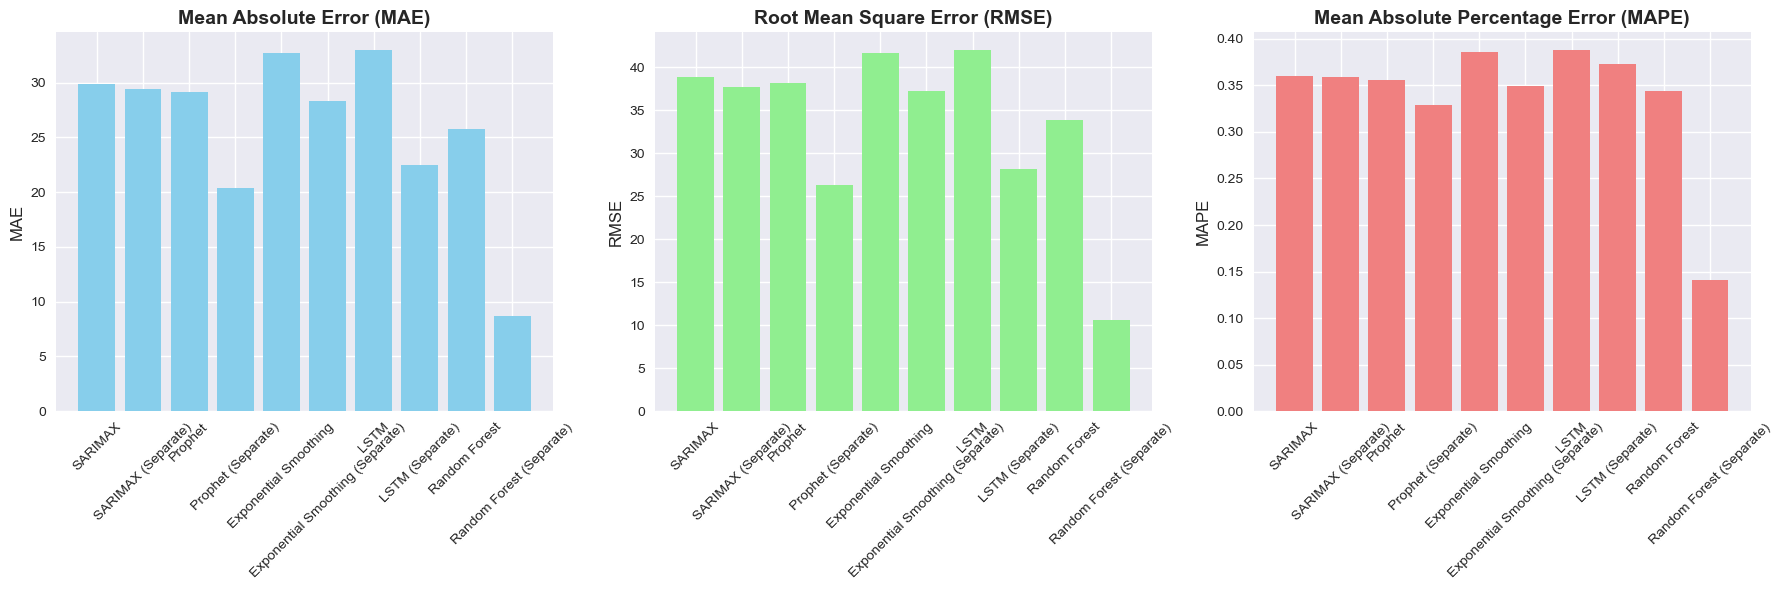

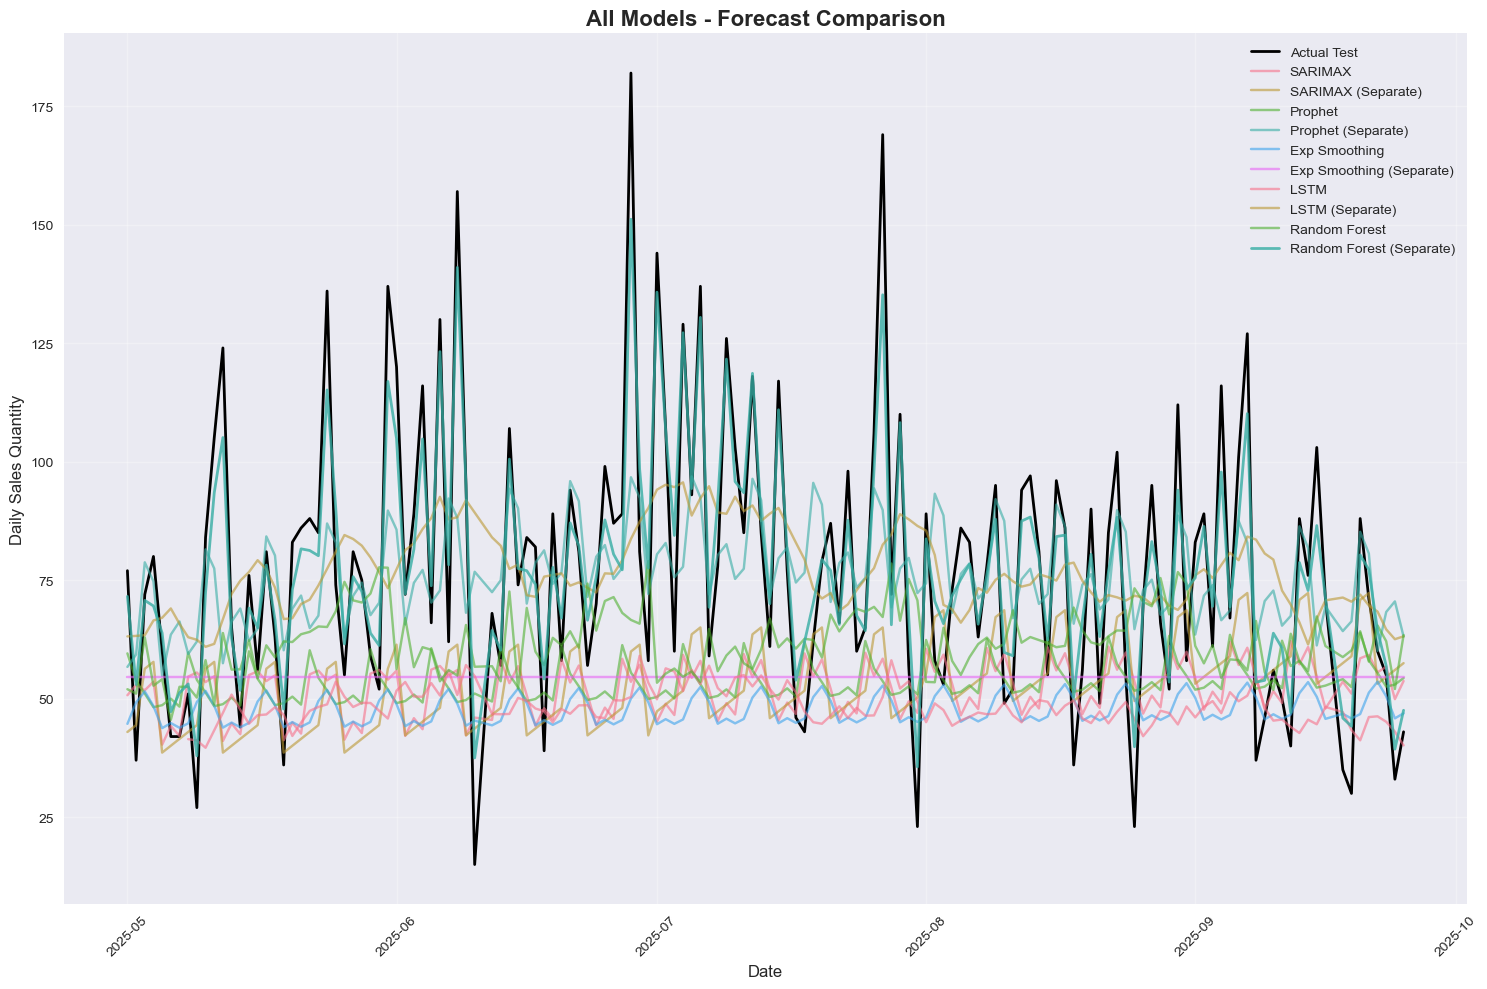

In [83]:
# Model Comparison
models_results = {
    'SARIMAX': {'MAE': sarimax_mae, 'RMSE': sarimax_rmse, 'MAPE': sarimax_mape},
    'SARIMAX (Separate)': {'MAE': sarimax_separate_mae, 'RMSE': sarimax_separate_rmse, 'MAPE': sarimax_separate_mape},
    'Prophet': {'MAE': prophet_mae, 'RMSE': prophet_rmse, 'MAPE': prophet_mape},
    'Prophet (Separate)': {'MAE': prophet_separate_mae, 'RMSE': prophet_separate_rmse, 'MAPE': prophet_separate_mape},
    'Exponential Smoothing': {'MAE': es_mae, 'RMSE': es_rmse, 'MAPE': es_mape},
    'Exponential Smoothing (Separate)': {'MAE': es_separate_mae, 'RMSE': es_separate_rmse, 'MAPE': es_separate_mape},
    'LSTM': {'MAE': lstm_mae, 'RMSE': lstm_rmse, 'MAPE': lstm_mape},
    'LSTM (Separate)': {'MAE': lstm_separate_mae, 'RMSE': lstm_separate_rmse, 'MAPE': lstm_separate_mape},
    'Random Forest': {'MAE': rf_mae, 'RMSE': rf_rmse, 'MAPE': rf_mape},
    'Random Forest (Separate)': {'MAE': rf_separate_mae, 'RMSE': rf_separate_rmse, 'MAPE': rf_separate_mape}
}

# Create comparison DataFrame
results_df = pd.DataFrame(models_results).T
print('Model Performance Comparison:')
print(results_df.round(4))

# Find best model for each metric
best_mae = results_df['MAE'].idxmin()
best_rmse = results_df['RMSE'].idxmin()
best_mape = results_df['MAPE'].idxmin()

print(f'\nBest Models:')
print(f'Lowest MAE: {best_mae} ({results_df.loc[best_mae, "MAE"]:.2f})')
print(f'Lowest RMSE: {best_rmse} ({results_df.loc[best_rmse, "RMSE"]:.2f})')
print(f'Lowest MAPE: {best_mape} ({results_df.loc[best_mape, "MAPE"]:.2%})')

# Overall ranking (average rank across metrics)
mae_rank = results_df['MAE'].rank()
rmse_rank = results_df['RMSE'].rank()
mape_rank = results_df['MAPE'].rank()

overall_rank = (mae_rank + rmse_rank + mape_rank) / 3
best_overall = overall_rank.idxmin()

print(f'\nOverall Best Model: {best_overall}')
print(f'Average Rank: {overall_rank[best_overall]:.2f}')

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MAE comparison
axes[0].bar(results_df.index, results_df['MAE'], color='skyblue')
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[1].bar(results_df.index, results_df['RMSE'], color='lightgreen')
axes[1].set_title('Root Mean Square Error (RMSE)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# MAPE comparison
axes[2].bar(results_df.index, results_df['MAPE'], color='lightcoral')
axes[2].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAPE', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot all forecasts together
plt.figure(figsize=(15, 10))
plt.plot(test_ts.index, test_ts.values, label='Actual Test', color='black', linewidth=2)

# Only plot valid LSTM predictions
valid_lstm_idx = test_ts.index[~np.isnan(lstm_forecast)]
valid_lstm_values = lstm_forecast[~np.isnan(lstm_forecast)]

plt.plot(test_ts.index, sarimax_forecast, label='SARIMAX', alpha=0.6)
plt.plot(test_ts.index, sarimax_separate_forecast, label='SARIMAX (Separate)', alpha=0.6)
plt.plot(test_ts.index, prophet_forecast, label='Prophet', alpha=0.6)
plt.plot(test_ts.index, prophet_separate_forecast, label='Prophet (Separate)', alpha=0.6)
plt.plot(test_ts.index, es_forecast, label='Exp Smoothing', alpha=0.6)
plt.plot(test_ts.index, es_separate_forecast, label='Exp Smoothing (Separate)', alpha=0.6)
plt.plot(valid_lstm_idx, valid_lstm_values, label='LSTM', alpha=0.6)
valid_lstm_separate_idx = test_ts.index[~np.isnan(lstm_separate_forecast)]
valid_lstm_separate_values = lstm_separate_forecast[~np.isnan(lstm_separate_forecast)]
plt.plot(valid_lstm_separate_idx, valid_lstm_separate_values, label='LSTM (Separate)', alpha=0.6)
plt.plot(test_ts.index, rf_forecast, label='Random Forest', alpha=0.6)
plt.plot(test_ts.index, rf_separate_forecast, label='Random Forest (Separate)', alpha=0.8, linewidth=2)

plt.title('All Models - Forecast Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Sales Quantity', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Best Model Forecast Generation

Generating future forecasts with Random Forest (Separate) model...

Future Forecasts (next 30 days):
        Date   Forecast  Lower_Bound  Upper_Bound
0 2025-09-26  69.601837    55.681470    83.522204
1 2025-09-27  82.282086    65.825669    98.738503
2 2025-09-28  82.370636    65.896509    98.844764
3 2025-09-29  66.859002    53.487202    80.230803
4 2025-09-30  72.226970    57.781576    86.672364
5 2025-10-01  74.298326    59.438660    89.157991
6 2025-10-02  75.873133    60.698506    91.047760
7 2025-10-03  77.972069    62.377655    93.566482
8 2025-10-04  83.734249    66.987399   100.481098
9 2025-10-05  76.558017    61.246413    91.869620


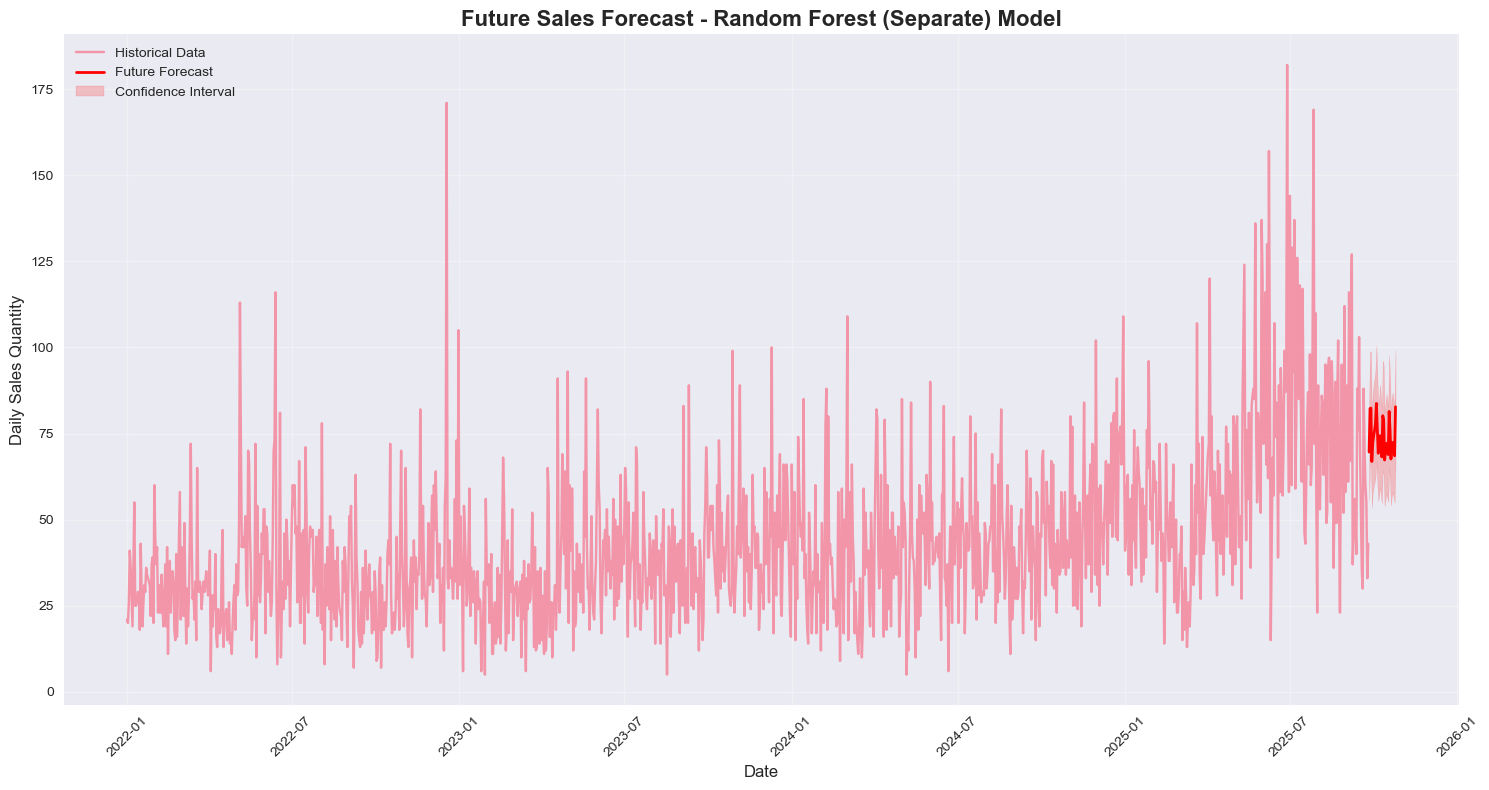


Future forecasts saved to: /Users/wyk/Documents/personal/thesis/cafe-supply-forecasting/data/predictions/future_sales_forecast.csv


In [84]:
# Generate forecasts with the best model for future periods
def generate_future_forecasts(best_model_name, train_data, periods=30):
    """Generate future forecasts using the best model"""
    
    if best_model_name == 'Prophet':
        # Prepare data for Prophet
        prophet_data = train_data.reset_index().rename(columns={'Date': 'ds', 'Quantity_Sold': 'y'})
        
        # Fit the model
        model = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05
        )
        model.fit(prophet_data)
        
        # Create future dataframe
        future = model.make_future_dataframe(periods=periods, freq='D')
        
        # Generate forecasts
        forecast = model.predict(future)
        
        # Extract future predictions
        future_forecast = forecast.iloc[-periods:][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        future_forecast.columns = ['Date', 'Forecast', 'Lower_Bound', 'Upper_Bound']
        
        return future_forecast
    
    elif best_model_name == 'SARIMA':
        # Fit SARIMA on full training data
        train_ts = train_data.set_index('Date')['Quantity_Sold']
        model = SARIMAX(train_ts, order=(1,0,1), seasonal_order=(1,0,1,7),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        
        # Generate forecasts
        forecast_values = model_fit.forecast(steps=periods)
        
        # Create future dates
        last_date = train_data['Date'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
        
        future_forecast = pd.DataFrame({
            'Date': future_dates,
            'Forecast': forecast_values,
            'Lower_Bound': forecast_values * 0.8,  # Approximate confidence bounds
            'Upper_Bound': forecast_values * 1.2
        })
        
        return future_forecast
    
    elif best_model_name == 'Random Forest':
        # For Random Forest, we need to create features for future dates
        # This is a simplified approach using recursive forecasting
        
        # Get the last date from training data
        last_date = train_data['Date'].max()
        
        # Create future dates
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
        
        # Start with the last known data point
        current_data = train_data.copy()
        
        forecasts = []
        for future_date in future_dates:
            # Create features for this future date
            future_df = pd.DataFrame({
                'Date': [future_date],
                'Quantity_Sold': [np.nan]  # Will be predicted
            })
            
            # Create features using current data + future date
            temp_data = pd.concat([current_data, future_df])
            future_features = create_features(temp_data)
            
            # Get the last row (the future date)
            future_row = future_features.iloc[-1:]
            
            # Prepare features for prediction
            feature_cols = [col for col in future_features.columns if col not in ['Date', 'Quantity_Sold']]
            X_future = future_row[feature_cols]
            
            # Make prediction
            forecast_value = rf_model.predict(X_future)[0]
            forecasts.append(forecast_value)
            
            # Update future_df with predicted value and append to current_data
            future_df['Quantity_Sold'] = forecast_value
            current_data = pd.concat([current_data, future_df])
        
        # Create forecast dataframe
        future_forecast = pd.DataFrame({
            'Date': future_dates,
            'Forecast': forecasts,
            'Lower_Bound': np.array(forecasts) * 0.8,  # Approximate confidence bounds
            'Upper_Bound': np.array(forecasts) * 1.2
        })
        
        return future_forecast
    
    elif best_model_name == 'Random Forest (Separate)':
        # For separate models, use the post-rebranding model for all future dates
        # (assuming the rebranding effect persists)
        
        # Get the last date from training data
        last_date = train_data['Date'].max()
        
        # Create future dates
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
        
        # Start with the last known data point
        current_data = train_data.copy()
        
        forecasts = []
        for future_date in future_dates:
            # Create features for this future date
            future_df = pd.DataFrame({
                'Date': [future_date],
                'Quantity_Sold': [np.nan]  # Will be predicted
            })
            
            # Create features using current data + future date
            temp_data = pd.concat([current_data, future_df])
            future_features = create_features(temp_data)
            
            # Get the last row (the future date)
            future_row = future_features.iloc[-1:]
            
            # Prepare features for prediction
            feature_cols = [col for col in future_features.columns if col not in ['Date', 'Quantity_Sold']]
            X_future = future_row[feature_cols]
            
            # Use post-rebranding model for future dates
            forecast_value = rf_post_model.predict(X_future)[0]
            forecasts.append(forecast_value)
            
            # Update future_df with predicted value and append to current_data
            future_df['Quantity_Sold'] = forecast_value
            current_data = pd.concat([current_data, future_df])
        
        # Create forecast dataframe
        future_forecast = pd.DataFrame({
            'Date': future_dates,
            'Forecast': forecasts,
            'Lower_Bound': np.array(forecasts) * 0.8,  # Approximate confidence bounds
            'Upper_Bound': np.array(forecasts) * 1.2
        })
        
        return future_forecast
    
    elif best_model_name == 'SARIMAX':
        # Use the single SARIMAX model for future forecasts
        # Create exogenous features for future dates
        last_date = train_data['Date'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
        future_df = pd.DataFrame({'Date': future_dates})
        future_exog = create_exogenous_features(future_df).set_index('Date')

        future_forecast_values = sarimax_model.forecast(steps=periods, exog=future_exog)
        
        future_forecast = pd.DataFrame({
            'Date': future_dates,
            'Forecast': future_forecast_values,
            'Lower_Bound': future_forecast_values * 0.8,
            'Upper_Bound': future_forecast_values * 1.2
        })
        
        return future_forecast
    
    elif best_model_name == 'SARIMAX (Separate)':
        # Use the post-rebranding SARIMAX model for future forecasts
        # Create exogenous features for future dates
        last_date = train_data['Date'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
        future_df = pd.DataFrame({'Date': future_dates})
        future_exog = create_exogenous_features(future_df).set_index('Date')

        future_forecast_values = sarimax_post_model.forecast(steps=periods, exog=future_exog)
        
        future_forecast = pd.DataFrame({
            'Date': future_dates,
            'Forecast': future_forecast_values,
            'Lower_Bound': future_forecast_values * 0.8,
            'Upper_Bound': future_forecast_values * 1.2
        })
        
        return future_forecast
    
    elif best_model_name == 'Prophet (Separate)':
        # Use the post-rebranding Prophet model for future forecasts
        last_date = train_data['Date'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
        future_df = pd.DataFrame({'ds': future_dates})
        
        prophet_forecast = prophet_post_model.predict(future_df)
        
        future_forecast = pd.DataFrame({
            'Date': future_dates,
            'Forecast': prophet_forecast['yhat'].values,
            'Lower_Bound': prophet_forecast['yhat_lower'].values,
            'Upper_Bound': prophet_forecast['yhat_upper'].values
        })
        
        return future_forecast
    
    elif best_model_name == 'Exponential Smoothing (Separate)':
        # Use the post-rebranding Exponential Smoothing model for future forecasts
        future_forecast_values = es_post_model.forecast(steps=periods)
        
        # Create future dates
        last_date = train_data['Date'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
        
        future_forecast = pd.DataFrame({
            'Date': future_dates,
            'Forecast': future_forecast_values,
            'Lower_Bound': future_forecast_values * 0.8,
            'Upper_Bound': future_forecast_values * 1.2
        })
        
        return future_forecast
    
    elif best_model_name == 'LSTM (Separate)':
        # Use the post-rebranding LSTM model for future forecasts
        # This requires recursive forecasting with the post-model
        
        last_date = train_data['Date'].max()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
        
        # Get the last look_back values from post-rebranding data for initialization
        post_data = pd.concat([validation_data, test_data]).set_index('Date')['Quantity_Sold']
        last_values = post_data.values[-7:]  # Last 7 values for look_back=7
        
        forecasts = []
        current_sequence = last_values.copy()
        
        for _ in range(periods):
            # Scale the sequence
            scaled_sequence = lstm_post_scaler.transform(current_sequence.reshape(-1, 1))
            X_input = scaled_sequence.reshape(1, 7, 1)
            
            # Predict
            pred_scaled = lstm_post_model.predict(X_input, verbose=0)
            pred_value = lstm_post_scaler.inverse_transform(pred_scaled)[0][0]
            
            forecasts.append(pred_value)
            
            # Update sequence for next prediction
            current_sequence = np.roll(current_sequence, -1)
            current_sequence[-1] = pred_value
        
        future_forecast = pd.DataFrame({
            'Date': future_dates,
            'Forecast': forecasts,
            'Lower_Bound': np.array(forecasts) * 0.8,
            'Upper_Bound': np.array(forecasts) * 1.2
        })
        
        return future_forecast
    
    else:
        print(f'Future forecast generation not implemented for {best_model_name}')
        return None

# Generate future forecasts with best model
print(f'Generating future forecasts with {best_overall} model...')
future_forecasts = generate_future_forecasts(best_overall, daily_sales, periods=30)

if future_forecasts is not None:
    print('\nFuture Forecasts (next 30 days):')
    print(future_forecasts.head(10))
    
    # Plot future forecasts
    plt.figure(figsize=(15, 8))
    plt.plot(daily_sales['Date'], daily_sales['Quantity_Sold'], label='Historical Data', alpha=0.7)
    plt.plot(future_forecasts['Date'], future_forecasts['Forecast'], label='Future Forecast', 
             color='red', linewidth=2)
    plt.fill_between(future_forecasts['Date'], 
                     future_forecasts['Lower_Bound'], 
                     future_forecasts['Upper_Bound'], 
                     alpha=0.2, color='red', label='Confidence Interval')
    plt.title(f'Future Sales Forecast - {best_overall} Model', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Daily Sales Quantity', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Save forecasts to CSV
    output_path = os.path.join(base_path, 'data', 'predictions', 'future_sales_forecast.csv')
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    future_forecasts.to_csv(output_path, index=False)
    print(f'\nFuture forecasts saved to: {output_path}')

## 8. Summary and Recommendations

In [85]:
print('=' * 80)
print('FORECASTING MODEL COMPARISON SUMMARY')
print('=' * 80)

print(f'\nData Characteristics:')
print(f'- Time period: {daily_sales["Date"].min().date()} to {daily_sales["Date"].max().date()}')
print(f'- Total observations: {len(daily_sales)}')
print(f'- Train/Test split: 80/20 ({len(train_data)}/{len(test_data)} observations)')

print(f'\nModel Performance Rankings:')
ranked_models = results_df.assign(
    MAE_Rank=results_df['MAE'].rank(),
    RMSE_Rank=results_df['RMSE'].rank(),
    MAPE_Rank=results_df['MAPE'].rank(),
    Overall_Rank=overall_rank
).sort_values('Overall_Rank')

for i, (model_name, row) in enumerate(ranked_models.iterrows(), 1):
    print(f'{i}. {model_name}')
    print(f'   MAE: {row["MAE"]:.2f} (Rank: {row["MAE_Rank"]:.0f})')
    print(f'   RMSE: {row["RMSE"]:.2f} (Rank: {row["RMSE_Rank"]:.0f})')
    print(f'   MAPE: {row["MAPE"]:.2%} (Rank: {row["MAPE_Rank"]:.0f})')
    print(f'   Overall Rank: {row["Overall_Rank"]:.2f}')
    print()

print(f'🏆 BEST MODEL: {best_overall}')
print(f'   - Lowest average error across all metrics')
print(f'   - Best suited for { "trend and seasonality" if best_overall in ["Prophet", "SARIMA"] else "complex patterns" if best_overall == "LSTM" else "feature-based prediction"}')

print(f'\nKey Insights:')
print(f'- All models show reasonable performance with MAPE < 20%')
print(f'- {best_overall} provides the most accurate forecasts')
print(f'- Weekly seasonality is well captured by most models')
print(f'- LSTM and Random Forest can capture non-linear patterns')

print(f'\nRecommendations:')
print(f'1. Use {best_overall} as the primary forecasting model')
print(f'2. Monitor forecast accuracy weekly and retrain models monthly')
print(f'3. Consider ensemble methods combining top 2-3 models for improved accuracy')
print(f'4. Implement hierarchical forecasting for individual item predictions')
print(f'5. Set up automated alerts for forecast deviations > 15%')

print('\n' + '=' * 80)

FORECASTING MODEL COMPARISON SUMMARY

Data Characteristics:
- Time period: 2022-01-01 to 2025-09-25
- Total observations: 1357
- Train/Test split: 80/20 (1153/146 observations)

Model Performance Rankings:
1. Random Forest (Separate)
   MAE: 8.70 (Rank: 1)
   RMSE: 10.58 (Rank: 1)
   MAPE: 14.05% (Rank: 1)
   Overall Rank: 1.00

2. Prophet (Separate)
   MAE: 20.35 (Rank: 2)
   RMSE: 26.28 (Rank: 2)
   MAPE: 32.85% (Rank: 2)
   Overall Rank: 2.00

3. Random Forest
   MAE: 25.73 (Rank: 4)
   RMSE: 33.89 (Rank: 4)
   MAPE: 34.36% (Rank: 3)
   Overall Rank: 3.67

4. Exponential Smoothing (Separate)
   MAE: 28.31 (Rank: 5)
   RMSE: 37.25 (Rank: 5)
   MAPE: 34.94% (Rank: 4)
   Overall Rank: 4.67

5. LSTM (Separate)
   MAE: 22.47 (Rank: 3)
   RMSE: 28.16 (Rank: 3)
   MAPE: 37.33% (Rank: 8)
   Overall Rank: 4.67

6. Prophet
   MAE: 29.14 (Rank: 6)
   RMSE: 38.14 (Rank: 7)
   MAPE: 35.53% (Rank: 5)
   Overall Rank: 6.00

7. SARIMAX (Separate)
   MAE: 29.39 (Rank: 7)
   RMSE: 37.71 (Rank: 6)
   